### Scanpy Integration
Trying to integrate [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) into scRNA-seq processing workflow.  
Testing out simple read-write, dimension reduction, and visualization with basic Scanpy tools.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [27]:
sc.settings.set_figure_params(dpi=100)

In [62]:
# reload fcc module while working
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
%%time
retina = sc.read('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz')
retina.shape # cells x genes

Only considering the two last: ['.tsv', '.gz'].
Only considering the two last: ['.tsv', '.gz'].
CPU times: user 2.62 s, sys: 48.1 ms, total: 2.67 s
Wall time: 2.68 s


(1326, 20478)

In [3]:
%time recipe_fcc(retina, mito_names=':mt-') # preprocess adata object

CPU times: user 1.52 s, sys: 135 ms, total: 1.65 s
Wall time: 1.65 s


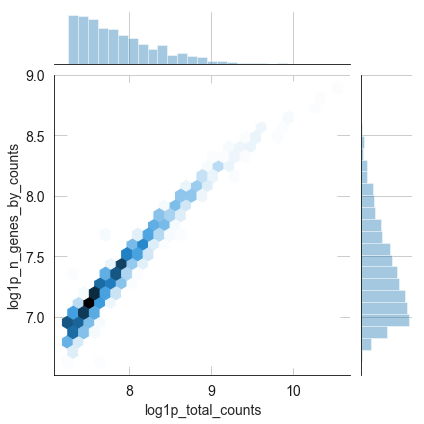

In [4]:
# generate some QC plots
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=retina.obs, kind="hex")

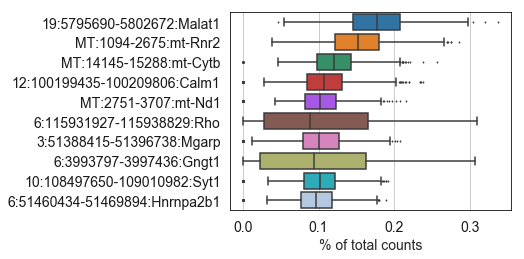

In [5]:
sc.pl.highest_expr_genes(retina, n_top=10)

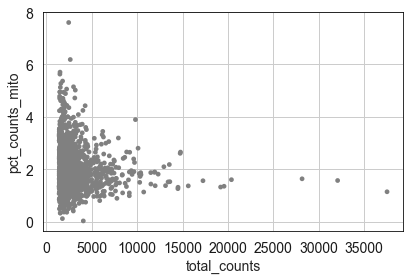

In [6]:
sc.pl.scatter(retina, x='total_counts', y='pct_counts_mito')

In [7]:
%%time
sc.pp.scale(retina, max_value=10)
# run PCA on log1p normalized counts and gf-icf scores to compare outputs
sc.tl.pca(data=retina, n_comps=100)

CPU times: user 1.2 s, sys: 310 ms, total: 1.51 s
Wall time: 251 ms


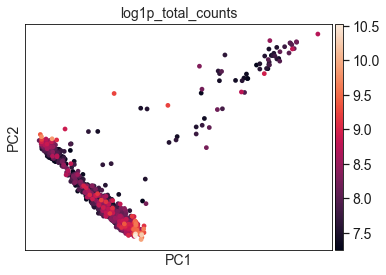

In [10]:
sc.pl.pca(retina, color='log1p_total_counts')

In [8]:
%%time
# create neighborhood graphs from both PCA results
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(retina, n_neighbors=30, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 2.89 s, sys: 104 ms, total: 2.99 s
Wall time: 2.53 s


In [9]:
%%time
# perform Louvain clustering on both graphs
sc.tl.louvain(retina, resolution=1.0, key_added='louvain', adjacency=retina.uns['neighbors']['connectivities'], random_state=18, copy=False)

CPU times: user 112 ms, sys: 3.1 ms, total: 115 ms
Wall time: 114 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


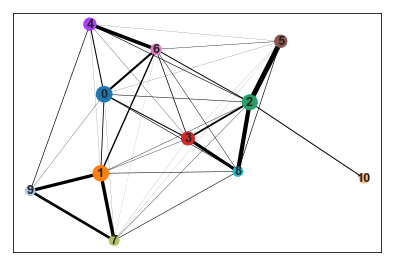

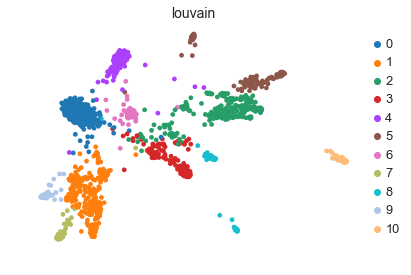

In [12]:
sc.tl.paga(retina) #perform PAGA
sc.pl.paga(retina)
sc.tl.draw_graph(retina, init_pos='paga')
sc.pl.draw_graph(retina, color='louvain', frameon=False)

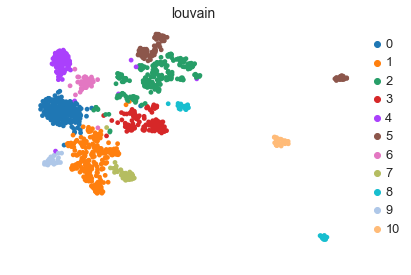

In [14]:
sc.tl.umap(retina, init_pos=sc.tl._utils.get_init_pos_from_paga(retina))
sc.pl.umap(retina, color='louvain', frameon=False)

In [15]:
%%time
sc.tl.rank_genes_groups(retina, 'louvain', method='wilcoxon')

CPU times: user 1.47 s, sys: 231 ms, total: 1.71 s
Wall time: 1.71 s


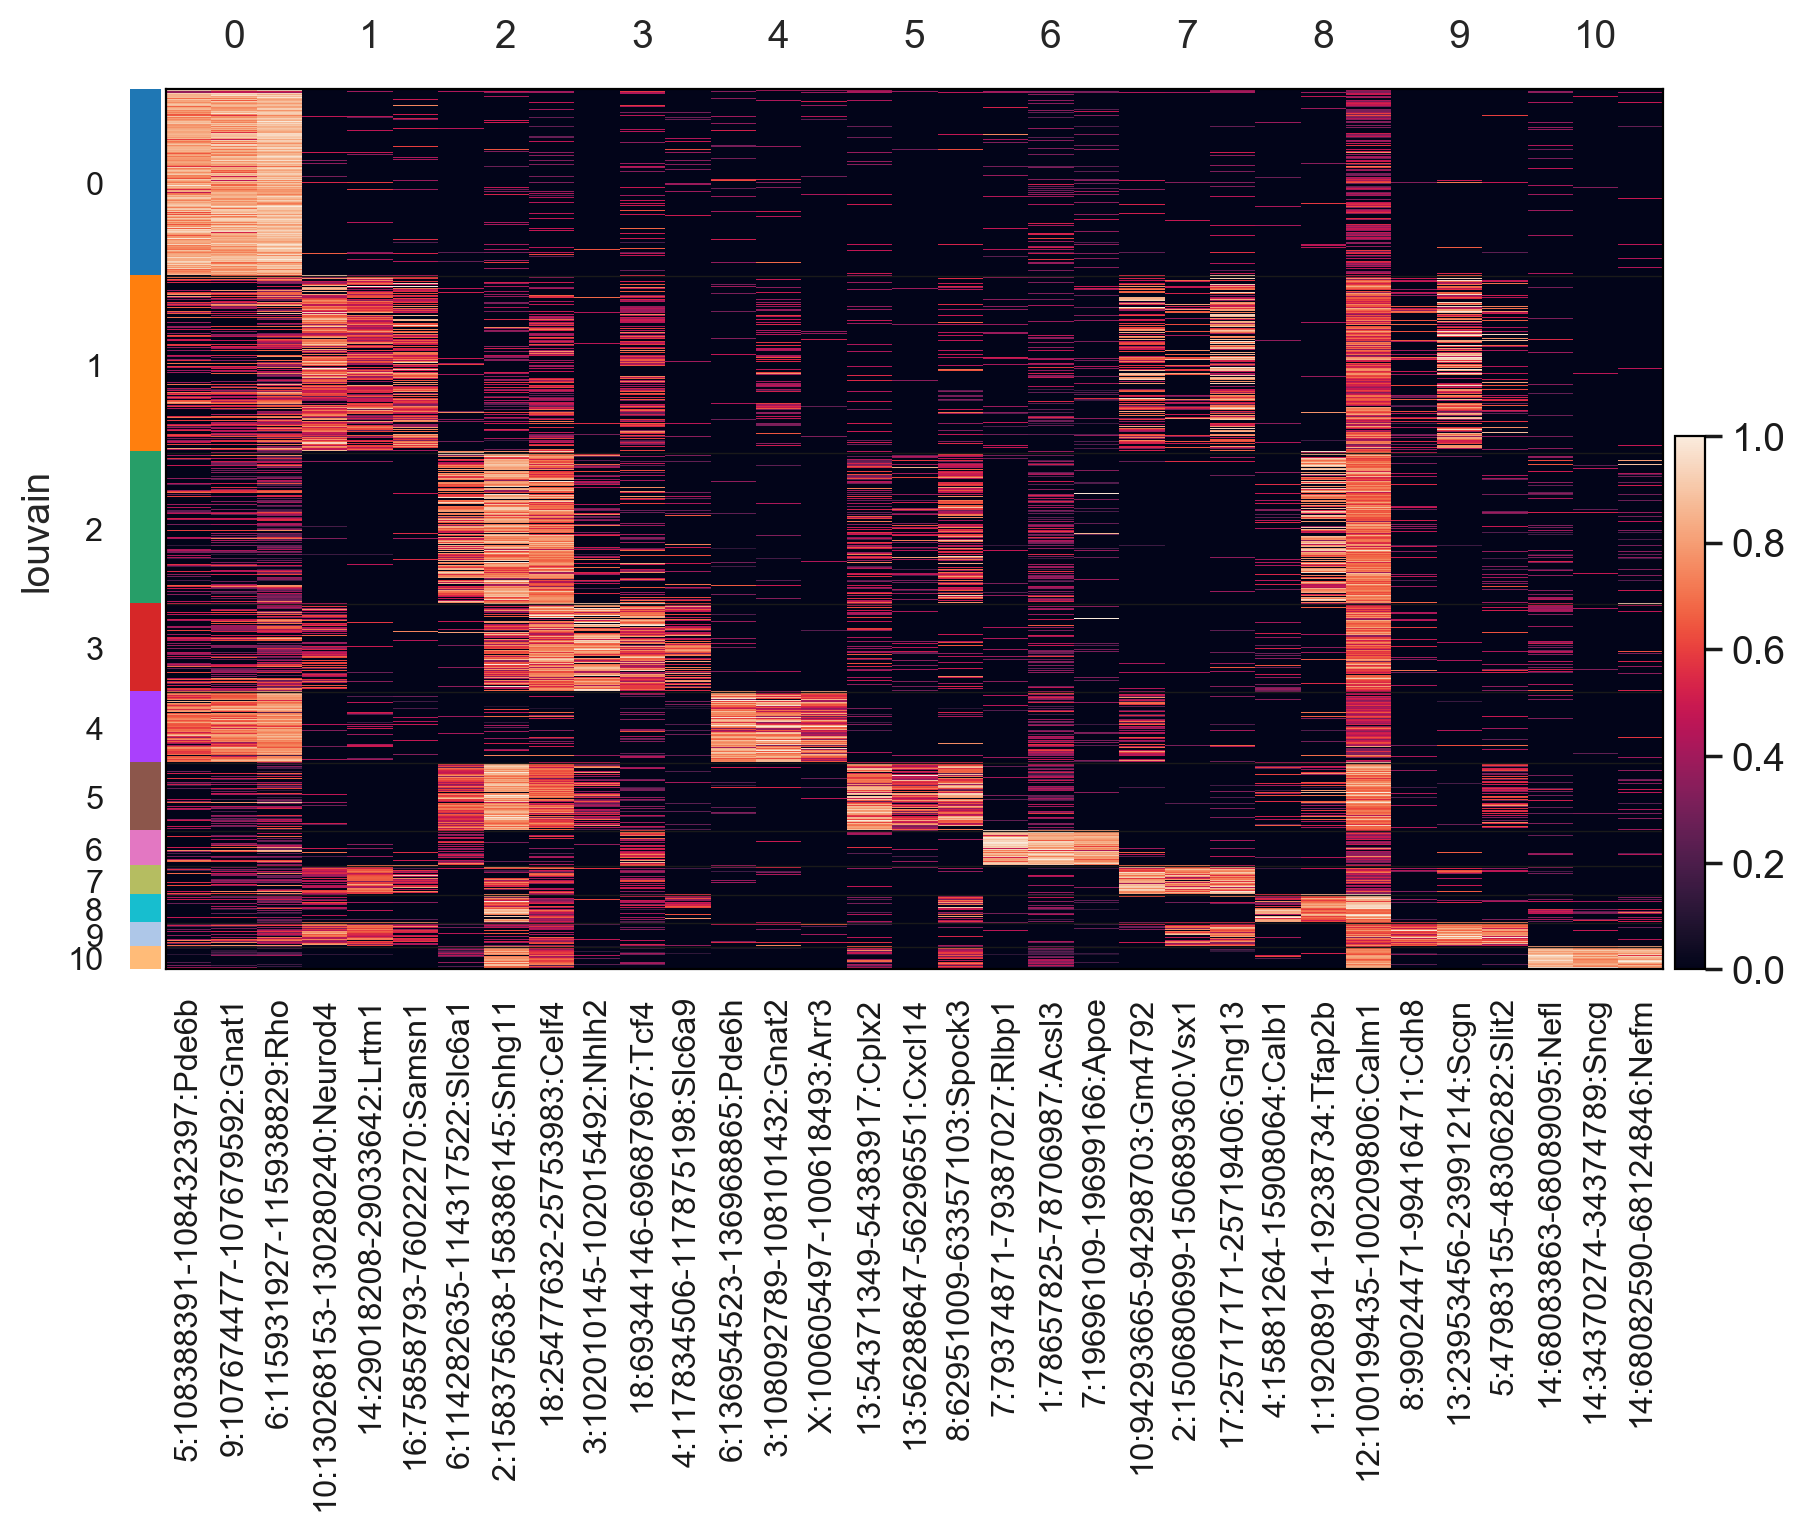

In [30]:
sc.pl.rank_genes_groups_heatmap(retina, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)

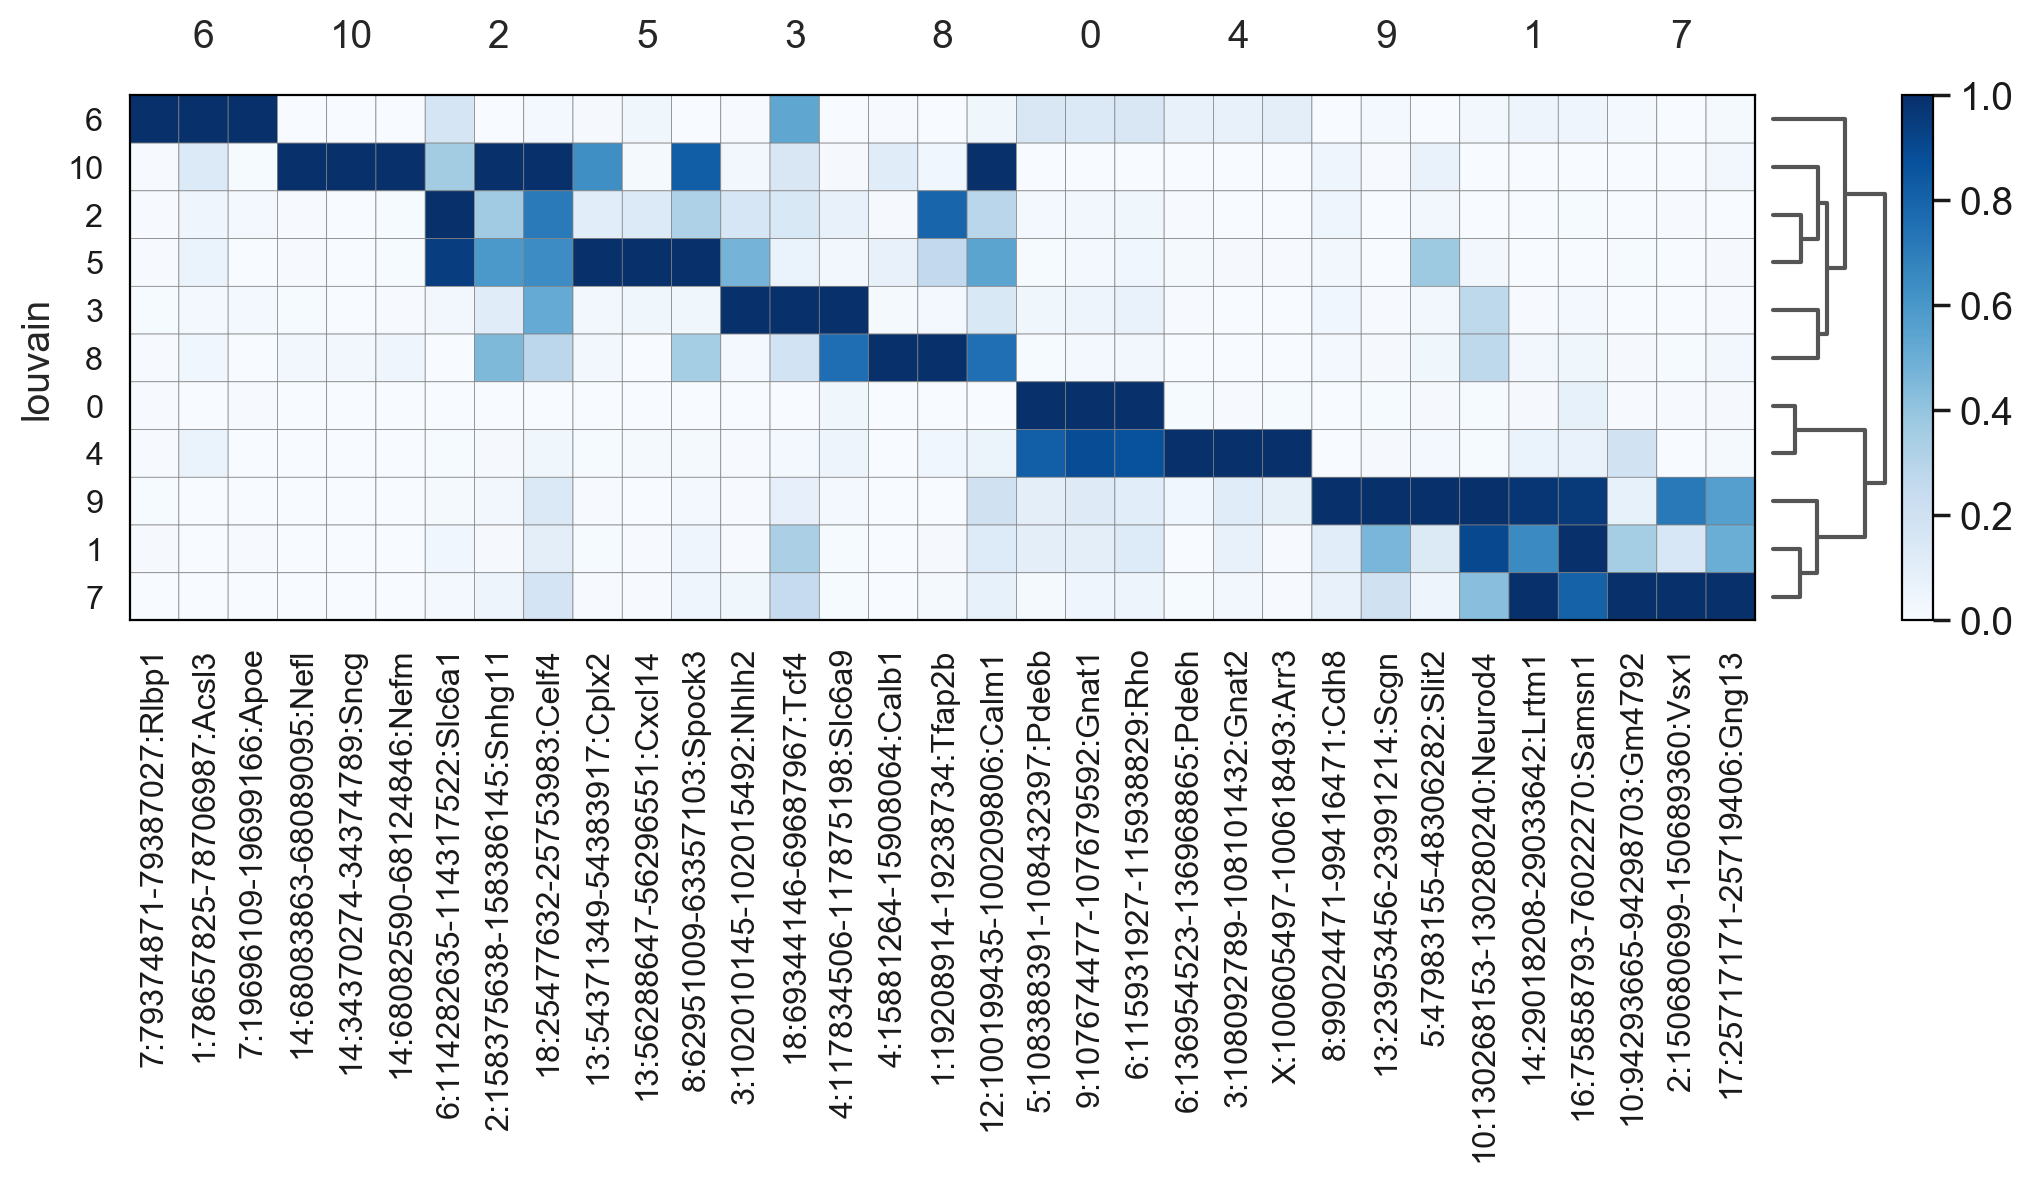

In [29]:
axs = sc.pl.rank_genes_groups_matrixplot(retina, n_genes=3, standard_scale='var', cmap='Blues')

In [67]:
retina_gf_icf_markers = gf_icf_markers(retina, n_genes=3)

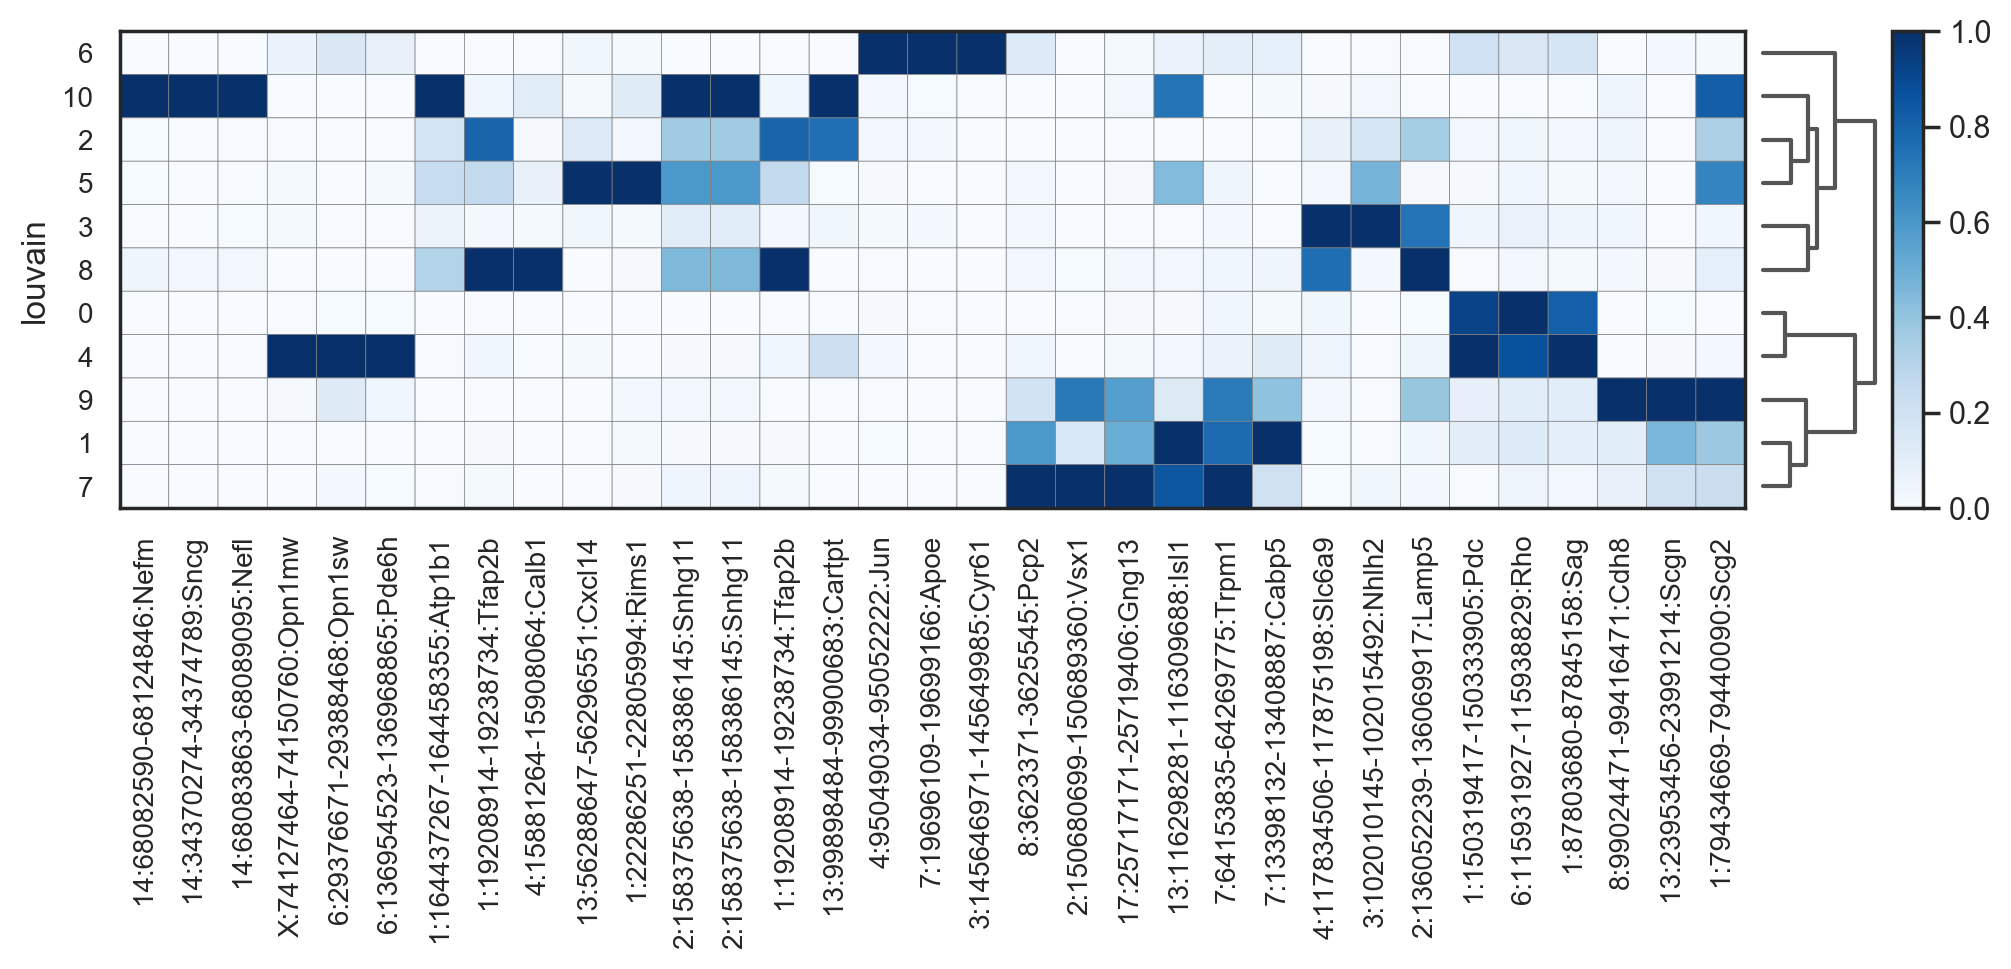

In [69]:
axs = sc.pl.matrixplot(retina, retina_gf_icf_markers.gene, groupby='louvain', standard_scale='var', cmap='Blues', dendrogram=True)

In [72]:
marker_genes = pd.DataFrame(retina.uns['rank_genes_groups']['names']).head(3)
marker_genes.values.flatten(order='F')

array(['5:108388391-108432397:Pde6b', '9:107674477-107679592:Gnat1',
       '6:115931927-115938829:Rho', '10:130268153-130280240:Neurod4',
       '14:29018208-29033642:Lrtm1', '16:75858793-76022270:Samsn1',
       '6:114282635-114317522:Slc6a1', '2:158375638-158386145:Snhg11',
       '18:25477632-25753983:Celf4', '3:102010145-102015492:Nhlh2',
       '18:69344146-69687967:Tcf4', '4:117834506-117875198:Slc6a9',
       '6:136954523-136968865:Pde6h', '3:108092789-108101432:Gnat2',
       'X:100605497-100618493:Arr3', '13:54371349-54383917:Cplx2',
       '13:56288647-56296551:Cxcl14', '8:62951009-63357103:Spock3',
       '7:79374871-79387027:Rlbp1', '1:78657825-78706987:Acsl3',
       '7:19696109-19699166:Apoe', '10:94293665-94298703:Gm4792',
       '2:150680699-150689360:Vsx1', '17:25717171-25719406:Gng13',
       '4:15881264-15908064:Calb1', '1:19208914-19238734:Tfap2b',
       '12:100199435-100209806:Calm1', '8:99024471-99416471:Cdh8',
       '13:23953456-23991214:Scgn', '5:47983155-483

In [79]:
len(set(marker_genes.values.flatten(order='F')).intersection(set(retina_gf_icf_markers.gene)))

16

In [80]:
len(marker_genes.values.flatten(order='F'))

33